In [87]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import os, tqdm
import pickle as pkl
import tqdm 
import random
import spacy
import string
from collections import Counter
import numpy as np
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from nltk.tokenize.toktok import ToktokTokenizer
%matplotlib inline
#train_data_tokens, all_train_tokens, val_data_tokens, test_data_tokens


def imdb_data_tokens(dataset_idx):
    train_targets = [0]*10000+[1]*10000
    val_targets = [0]*2500+[1]*2500
    test_targets = [0]*12500+[1]*12500
    filenames_list = [
        ['imdb_train_data_tokens.p','imdb_val_data_tokens.p','imdb_test_data_tokens.p'],
        ['toktok_imdb_train_data_tokens.p','toktok_imdb_val_data_tokens.p','toktok_imdb_test_data_tokens.p'],
        ['imdb_without_br_train_data_tokens.p','imdb_without_br_val_data_tokens.p','imdb_without_br_test_data_tokens.p'],
    ]
    train_data_tokens = unpickle_from_file(filenames_list[dataset_idx][0])
    val_data_tokens = unpickle_from_file(filenames_list[dataset_idx][1])
    test_data_tokens = unpickle_from_file(filenames_list[dataset_idx][2])
    return train_data_tokens, train_targets, val_data_tokens, val_targets, test_data_tokens, test_targets

# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def generate_ngram_data(n, data_tokens):
    if n == 1:
        return data_tokens
    ngram_data_tokens = []
    for sentence in data_tokens:
        ngram_sentence_tokens = []
        for i in range(len(sentence)-n):
            token_list = []
            for j in range(n):
                token_list.append(sentence[i+j])
            ngram = ' '.join(token_list)
            ngram_sentence_tokens.append(ngram)
        ngram_data_tokens.append(ngram_sentence_tokens)
    return ngram_data_tokens

def build_vocab(all_tokens, max_vocab_size):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

def token2index_dataset(tokens_data, token2id):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

class IMDBDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label, key]

def imdb_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    indices_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        indices_list.append(datum[3])
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)).cuda(), torch.cuda.LongTensor(length_list), torch.cuda.LongTensor(label_list), torch.cuda.LongTensor(indices_list)]

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim, target_size):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,target_size)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float() 
     
        # return logits
        out = self.linear(out.float())
        return out
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels, _ in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

def unpickle_from_file(file_name):
    with open(file_name, 'rb') as handle:
        return pkl.load(handle)
#
def plot_train_validation(loss_lists, val_acc_lists, param, string_xticks=False):
    figure = plt.figure(figsize = (20, 5))
    figure.subplots_adjust(wspace = 0.05, hspace = 0.05)

    figure.add_subplot(1,3,1)
    for key, loss_list in loss_lists.items():
        plt.plot(list(range(len(loss_list))), loss_list, alpha=0.5, label=str(key))
    plt.legend()
    plt.title("{}, training".format(param))
    
    figure.add_subplot(1,3,2)
    val_max = 0
    val_max_key = 0
    val_key_list = []
    val_max_list = []
    for key, val_acc_list in val_acc_lists.items():
        plt.plot(list(range(len(val_acc_list))), val_acc_list, alpha=0.5, label=str(key))
        current_max = max(val_acc_list)
        val_key_list.append(key)
        val_max_list.append(current_max)
        if current_max > val_max:
            val_max = current_max
            val_max_key = key
            
    plt.legend()
    plt.title("{}, validation".format(param))
    
    figure.add_subplot(1,3,3)
    if string_xticks:
        x = list(range(len(val_key_list)))
        my_xticks = val_key_list
        plt.xticks(x, my_xticks)
        plt.plot(x, val_max_list)
    else:
        plt.plot(val_key_list, val_max_list)
    plt.title("best validation acc for each {}".format(param))
    print(val_key_list, val_max_list)

    plt.show()
    
    return val_max_key, val_max

# IMDB Large Movie Review Dataset http://ai.stanford.edu/~amaas/data/sentiment/

## Train_val_test data generation

In [ ]:
path_to_train_pos = '../aclImdb/train/pos/'
path_to_train_neg = '../aclImdb/train/neg/'
path_to_test_pos = '../aclImdb/test/pos/'
path_to_test_neg = '../aclImdb/test/neg/'

results = []
for path_to_dir in [path_to_train_pos, path_to_train_neg, path_to_test_pos, path_to_test_neg]:
    result = []
    for file in tqdm.tqdm(os.listdir(path_to_dir)):
        if file.endswith(".txt"):
            with open(os.path.join(path_to_dir, file),'r') as f:
                lines = f.readlines()
            if len(lines) != 1:
                print("found len(lines) > 1", os.path.join(path_to_dir, file))
            result.append(lines[0])
    results.append(result)

imdb_train = results[0][:10000] + results[1][:10000]
imdb_val = results[0][10000:]+ results[1][10000:]
imdb_test = results[2] + results[3] 

In [26]:
def create_fasttext_file(pos_data, neg_data, outfile_name):
    with open(outfile_name, 'w') as fout:
        for i, sent in enumerate(pos_data):
            line = "__label__" + str(0) + " " + sent.replace('\n', ' ') + "\n"
            fout.write(line)
        for i, sent in enumerate(neg_data):
            line = "__label__" + str(1) + " " + sent.replace('\n', ' ') + "\n"
            fout.write(line)
            
create_fasttext_file(results[0][:10000], results[1][:10000], 'imdb.train') 
create_fasttext_file(results[0][10000:], results[1][10000:], 'imdb.val') 
create_fasttext_file(results[2], results[3], 'imdb.test') 

In [39]:
def read_fasttext_format(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    new_lines = []
    targets = []
    for line in lines:
        split_line = line.strip().split()
        targets.append(int(split_line[0][-1]))
        new_lines.append( ' '.join(split_line[1:]) )
    return new_lines
        
filenames = ['imdb.train','imdb.val','imdb.test']
imdb_train = read_fasttext_format(filenames[0])
imdb_val = read_fasttext_format(filenames[1])
imdb_test = read_fasttext_format(filenames[2])

In [19]:
# Load English tokenizer, tagger, parser, NER and word vectors

tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize(sent):
    tokens = tokenizer(sent)
    return [token.text.lower() for token in tokens if (token.text not in punctuations)]

def tokenize_dataset(dataset, tokenize_func):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in tqdm.tqdm(dataset):
        tokens = tokenize_func(sample)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

In [ ]:
# Tokenize using spacy

# val set tokens
print ("Tokenizing val data")
imdb_val_data_tokens, _ = tokenize_dataset(imdb_val, tokenize)
#pkl.dump(imdb_val_data_tokens, open("imdb_val_data_tokens.p", "wb"))

# test set tokens
print ("Tokenizing test data")
imdb_test_data_tokens, _ = tokenize_dataset(imdb_test, tokenize)
#pkl.dump(imdb_test_data_tokens, open("imdb_test_data_tokens.p", "wb"))

# train set tokens
print ("Tokenizing train data")
imdb_train_data_tokens, imdb_all_train_tokens = tokenize_dataset(imdb_train, tokenize)
#pkl.dump(imdb_train_data_tokens, open("imdb_train_data_tokens.p", "wb"))
#pkl.dump(imdb_all_train_tokens, open("imdb_all_train_tokens.p", "wb"))

print("done.")

In [31]:
train_data_tokens = pkl.load(open("imdb_train_data_tokens.p", "rb"))
all_train_tokens = pkl.load(open("imdb_all_train_tokens.p", "rb"))

val_data_tokens = pkl.load(open("imdb_val_data_tokens.p", "rb"))
test_data_tokens = pkl.load(open("imdb_test_data_tokens.p", "rb"))

# double checking
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 4820161


In [89]:
MAX_SENTENCE_LENGTH = 200
#BATCH_SIZE = 32
#emb_dim = 128


def ngram_train(name, n, max_vocab_size, emb_dim, num_epochs, learning_rate, batch_size, optimizer_type='adam', linear_annealing_coeff=100):
    
    assert n in [1,2,3,4]
    
    experiment_name = "imdb_{}_loss_ngram_{}_maxvocab_{}_emb_{}_batch_{}_lr_{}".format(
        name, 
        n, 
        max_vocab_size,
        emb_dim, 
        batch_size, 
        learning_rate
    )
    try:
        os.mkdir(experiment_name)
    except:
        print("this experiment is already done.")
        return
    
    train_ngram_data_tokens = generate_ngram_data(n, train_data_tokens)
    val_ngram_data_tokens = generate_ngram_data(n, val_data_tokens)
    test_ngram_data_tokens = generate_ngram_data(n, test_data_tokens)
    all_train_ngram_tokens = []
    for sentence in train_ngram_data_tokens:
        for token in sentence:
            all_train_ngram_tokens.append(token)
    # save index 0 for unk and 1 for pad
    PAD_IDX = 0
    UNK_IDX = 1

    token2id, id2token = build_vocab(all_train_ngram_tokens, max_vocab_size)
    random_token_id = random.randint(0, len(id2token)-1)
    random_token = id2token[random_token_id]

    print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
    print ("Token {}; token id {}".format(random_token, token2id[random_token]))
    
    train_data_ngram_indices = token2index_dataset(train_ngram_data_tokens, token2id)
    val_data_ngram_indices = token2index_dataset(val_ngram_data_tokens, token2id)
    test_data_ngram_indices = token2index_dataset(test_ngram_data_tokens, token2id)

    # double checking
    print ("Train dataset size is {}".format(len(train_data_ngram_indices)))
    print ("Val dataset size is {}".format(len(val_data_ngram_indices)))
    print ("Test dataset size is {}".format(len(test_data_ngram_indices)))
    
    
    train_dataset = IMDBDataset(train_data_ngram_indices, train_targets)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=batch_size,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)

    val_dataset = IMDBDataset(val_data_ngram_indices, val_targets)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=batch_size,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)

    test_dataset = IMDBDataset(test_data_ngram_indices, test_targets)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=batch_size,
                                               collate_fn=imdb_collate_func,
                                               shuffle=False)
    
    model = BagOfWords(len(id2token), emb_dim, 2).cuda()

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    if optimizer_type == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_type == 'sgd' or optimizer_type == 'sgd_linear_annealing':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    else:
        raise NotImplementedError()

    
    loss_list = []
    val_acc_list = []
    for epoch in range(num_epochs):
        if optimizer_type == 'sgd_linear_annealing':
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate - epoch*learning_rate/linear_annealing_coeff)
        for i, (data, lengths, labels, _) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            loss_list.append(loss.item())
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                if len(val_acc_list) == 0 or val_acc > max(val_acc_list):
                    save_path = "{}/epoch_{}_step_{}.p".format(experiment_name, epoch, i)
                    torch.save(model.state_dict(), save_path)
                    print("saved", save_path)
                val_acc_list.append(val_acc)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    #loss_lists[emb_dim] = loss_list
    #val_acc_lists[emb_dim] = val_acc_list
    pkl.dump(loss_list, open("{}/loss.p".format(experiment_name), "wb"))
    pkl.dump(val_acc_list, open("{}/acc.p".format(experiment_name), "wb"))

In [74]:
MAX_SENTENCE_LENGTH = 200
#BATCH_SIZE = 32
#emb_dim = 128

def convert_indices_to_string(example, id2token, padding_index):
    tokens = []
    for each in example:
        if each == padding_index:
            break
        tokens.append(id2token[each])
    return ' '.join(tokens)

def ngram_show_result(model_path, n, max_vocab_size, emb_dim, batch_size, phase):
    
    assert n in [1,2,3,4]
    
    assert os.path.exists(model_path)
    
    assert phase in ["val", "test"]
    
    train_ngram_data_tokens = generate_ngram_data(n, train_data_tokens)
    val_ngram_data_tokens = generate_ngram_data(n, val_data_tokens)
    test_ngram_data_tokens = generate_ngram_data(n, test_data_tokens)
    all_train_ngram_tokens = []
    for sentence in train_ngram_data_tokens:
        for token in sentence:
            all_train_ngram_tokens.append(token)
    # save index 0 for unk and 1 for pad
    PAD_IDX = 0
    UNK_IDX = 1

    token2id, id2token = build_vocab(all_train_ngram_tokens, max_vocab_size)

    train_data_ngram_indices = token2index_dataset(train_ngram_data_tokens, token2id)
    val_data_ngram_indices = token2index_dataset(val_ngram_data_tokens, token2id)
    test_data_ngram_indices = token2index_dataset(test_ngram_data_tokens, token2id)

    # double checking
    print ("Train dataset size is {}".format(len(train_data_ngram_indices)))
    print ("Val dataset size is {}".format(len(val_data_ngram_indices)))
    print ("Test dataset size is {}".format(len(test_data_ngram_indices)))
    
    
    #train_dataset = IMDBDataset(train_data_ngram_indices, train_targets)
    #train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
    #                                           batch_size=batch_size,
    #                                           collate_fn=imdb_collate_func,
    #                                           shuffle=True)

    val_dataset = IMDBDataset(val_data_ngram_indices, val_targets)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=batch_size,
                                               collate_fn=imdb_collate_func,
                                               shuffle=True)

    test_dataset = IMDBDataset(test_data_ngram_indices, test_targets)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=batch_size,
                                               collate_fn=imdb_collate_func,
                                               shuffle=False)
    
    model = BagOfWords(len(id2token), emb_dim, 2).cuda()

    # Criterion and Optimizer
    #criterion = torch.nn.CrossEntropyLoss()  
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.load_state_dict(torch.load(model_path))
    
    if phase=="test":
        test_acc = test_model(test_loader, model)
        print("test acc:", test_acc)
    elif phase=="val":
        val_acc = test_model(val_loader, model)
        print("val acc:", val_acc)
        
        #correct = 0
        #total = 0
        model.eval()
        correct_examples_list, wrong_examples_list = [], []
        for data, lengths, labels, indices in val_loader:
            if len(correct_examples_list) >= 3 and len(wrong_examples_list) >= 3:
                break
            data_batch, length_batch, label_batch = data, lengths, labels
            outputs = F.softmax(model(data_batch, length_batch), dim=1)
            predicted = outputs.max(1, keepdim=True)[1]

            #print()
            #total += labels.size(0)
            #correct += predicted.eq(labels.view_as(predicted)).sum().item()
            correct_list = predicted.eq(labels.view_as(predicted)).flatten().data.cpu().numpy()
            label_batch = label_batch.flatten().data.cpu().numpy()
            prediction = predicted.flatten().data.cpu().numpy()
            #print(correct_list)
            for i in range(data_batch.shape[0]):
                is_correct = correct_list[i]
                if len(correct_examples_list) >= 3 and len(wrong_examples_list) >= 3:
                    break
                if is_correct:
                    correct_examples_list.append( (convert_indices_to_string(data_batch[i], id2token, PAD_IDX), label_batch[i], prediction[i], indices[i]) )
                else:
                    wrong_examples_list.append( (convert_indices_to_string(data_batch[i], id2token, PAD_IDX), label_batch[i], prediction[i], indices[i]) )
            
        print("Correct examples:")
        label_to_neg_pos = {
            0: "pos",
            1: "neg"
        }
        for sentence, label, prediction, index in correct_examples_list[:3]:
            print("true label is", label_to_neg_pos[label], ", prediction is", label_to_neg_pos[prediction], ":\n", sentence) 
            print("original sentense")       
            print(imdb_val[index])
        print("\nWrong examples:")
        for sentence, label, prediction, index in wrong_examples_list[:3]:
            print("true label is", label_to_neg_pos[label], ", prediction is", label_to_neg_pos[prediction], ":\n", sentence)
            print("original sentense")
            print(imdb_val[index])
                    


# Hyperparam search for ngram (n=1..4)

In [ ]:
# redo after changing output dimension to 2
train_data_tokens, train_targets, val_data_tokens, val_targets, test_data_tokens, test_targets = imdb_data_tokens(0)

ngram_train("spacy", 1, 10000, 128, 25, 0.01, 32)
ngram_train("spacy", 2, 10000, 128, 25, 0.01, 32)
ngram_train("spacy", 3, 10000, 128, 25, 0.01, 32)
ngram_train("spacy", 4, 10000, 128, 25, 0.01, 32)

[1, 2, 3, 4] [87.52, 83.74, 78.22, 72.72]


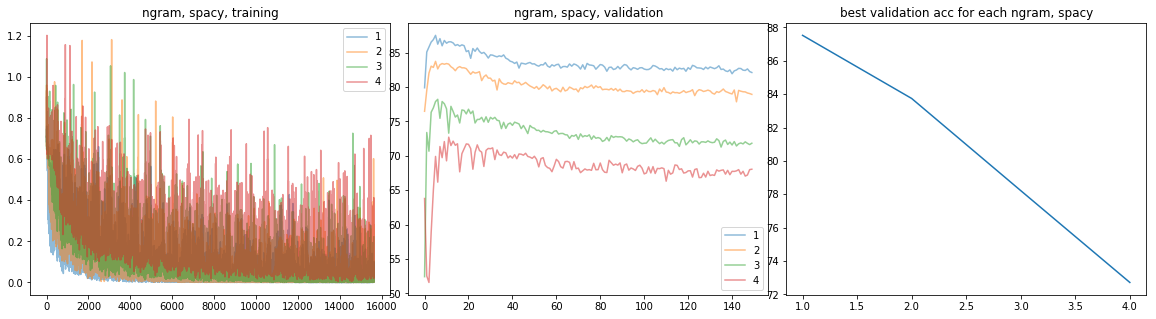

(1, 87.52)

In [63]:
#SHOW GRAPH
loss_lists, val_acc_lists = dict(), dict()
for n in [1, 2,3,4]:
    loss_lists[n] = unpickle_from_file('imdb_spacy_loss_ngram_{}_maxvocab_10000_emb_128_batch_32_lr_0.01/loss.p'.format(n))
    val_acc_lists[n] = unpickle_from_file('imdb_spacy_loss_ngram_{}_maxvocab_10000_emb_128_batch_32_lr_0.01/acc.p'.format(n))
best_hyperparam, best_val = plot_train_validation(loss_lists, val_acc_lists, "ngram, spacy")
best_hyperparam, best_val

In [144]:
#SHOW 3 CORRECT 3 INCORRECT RESULT OF THE MODEL, VALIDATION SET
ngram_show_result('imdb_spacy_loss_ngram_1_maxvocab_10000_emb_128_batch_32_lr_0.01/epoch_0_step_600.p', 1, 10000, 128, 128, "val")

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
val acc: 87.52
Correct examples:
true label is pos , prediction is pos :
 this movie is one i strongly recommend it 's about a boy stanley <unk> <unk> <unk> who is wrongly convicted of a crime and sent to camp green lake a boys <unk> center there he is forced to dig holes 5 feet deep and 5 feet in <unk> while there he meets the other boys of the camp zero <unk> <unk> <unk> x ray and <unk> all of them are digging not to build <unk> but to find outlaw kate <unk> 's treasure throughout the movie and book stanley learns more about the past more about himself and more about digging holes i give this movie a <unk> because i am very <unk> when it comes to books to movies i want the movie to follow the book exactly but still it did real well
true label is pos , prediction is pos :
 this film takes you on one family 's impossible journey and makes you feel every step of their odyssey beautifully acted and photograph

# A different tokenizer
Let's try toktok

In [ ]:
# tokenize using toktok
toktok = ToktokTokenizer()

def toktok_tokenize(sent):
    tokens = toktok.tokenize(sent)
    return [token.lower() for token in tokens if (token not in punctuations)]

imdb_val_data_tokens, _ = tokenize_dataset(imdb_val, toktok_tokenize)
imdb_test_data_tokens, _ = tokenize_dataset(imdb_test, toktok_tokenize)
imdb_train_data_tokens, imdb_all_train_tokens = tokenize_dataset(imdb_train, toktok_tokenize)
pkl.dump(imdb_val_data_tokens, open("toktok_imdb_val_data_tokens.p", "wb"))
pkl.dump(imdb_test_data_tokens, open("toktok_imdb_test_data_tokens.p", "wb"))
pkl.dump(imdb_train_data_tokens, open("toktok_imdb_train_data_tokens.p", "wb"))
pkl.dump(imdb_all_train_tokens, open("toktok_imdb_all_train_tokens.p", "wb"))

In [22]:
# LOAD TOKTOK WITHOUT PREPROCESSING

train_data_tokens = pkl.load(open("toktok_imdb_train_data_tokens.p", "rb"))
all_train_tokens = pkl.load(open("toktok_imdb_all_train_tokens.p", "rb"))

val_data_tokens = pkl.load(open("toktok_imdb_val_data_tokens.p", "rb"))
test_data_tokens = pkl.load(open("toktok_imdb_test_data_tokens.p", "rb"))

# double checking
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 4789452


In [ ]:
# redo after changing output dimension to 2
train_data_tokens, train_targets, val_data_tokens, val_targets, test_data_tokens, test_targets = imdb_data_tokens(1)

ngram_train("toktok", 1, 10000, 128, 25, 0.01, 32)

['spacy', 'toktok'] [87.52, 86.64]


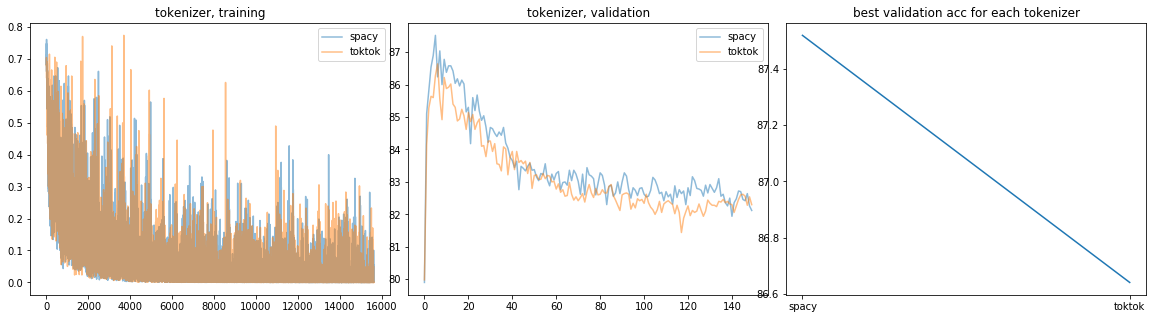

('spacy', 87.52)

In [64]:
#SHOW GRAPH
loss_lists, val_acc_lists = dict(), dict()

for n in ["spacy", "toktok"]:
    loss_lists[n] = unpickle_from_file('imdb_{}_loss_ngram_1_maxvocab_10000_emb_128_batch_32_lr_0.01/loss.p'.format(n))
    val_acc_lists[n] = unpickle_from_file('imdb_{}_loss_ngram_1_maxvocab_10000_emb_128_batch_32_lr_0.01/acc.p'.format(n))

best_hyperparam, best_val = plot_train_validation(loss_lists, val_acc_lists, "tokenizer", True)
best_hyperparam, best_val

In [150]:
#SHOW 3 CORRECT 3 INCORRECT RESULT OF THE MODEL, VALIDATION SET
ngram_show_result('imdb_toktok_loss_ngram_1_maxvocab_10000_emb_128_batch_32_lr_0.01/epoch_1_step_100.p', 1, 10000, 128, 128, "val")

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
val acc: 52.32
Correct examples:
true label is neg , prediction is neg :
 set in a post apocalyptic environment <unk> led by <unk> job <unk> over the human population they basically keep them as <unk> as they need fresh human blood to live off <unk> and her brother managed to survive one of their attacks when she was a kid and years have past when she came face to face with the <unk> again but this time she 's saved by the cyborg gabriel who was created to destroy all <unk> job and his men are on their way to capture a largely populated city while <unk> with revenge on mind <unk> gabriel to train her in the way of killing <unk> and she 'll get him to gabriel   cheap low rent cyborg post apocalyptic <unk> by writer director albert <unk> who made cyborg prior to it and the <unk> <unk> the same year is reasonably a misguided <unk> of junk with some interesting <unk> very little structure makes its way into the

## preprocessing for tokenization
One potential problem with this dataset is the presence of br html tag, which ends up generating incorrect token. Let's try 

In [51]:
print("before:\n", imdb_train[-1])
print("after:\n", imdb_train[-1].replace('<br />', ' '))

before:
 "The Secretary" is one of those cheesy, cliched, "thrillers" that one is subjected to watching on a Sunday afternoon, when there is virtually nothing else on. While the plot (a demented woman becomes jealous of all who succeed over her in the office and decides to do whatever she can to stop them) may be one of a kind, I recognized countless plot twists, probably taken from other TV movies that I had been subjected to for the very same reason.<br /><br />To make matters worse, I was not wild about the cast. Mel Harris is one of those actresses who appears in so many TV movies as either a "mom" or some sort of "victim" of foul play or abuse, that one must wonder the kind of life she leads. In this one, she gets the joy of playing a mom AND a victim of psycho secretary Sheila Kelly, who was not a very good choice as the villain. While Sheila Kelly has made some good career moves(Singles, Breaking In, and I guess, Law and Order), she is also beset by a string of pitiful TV movie 

In [47]:
# Tokenize using spacy
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize_without_br(sent):
    tokens = tokenizer(sent.replace('<br />', ' '))
    return [token.text.lower() for token in tokens if (token.text not in punctuations)]

In [52]:

# val set tokens
print ("Tokenizing val data")
#imdb_val_data_tokens, _ = tokenize_dataset(imdb_val, tokenize_without_br)
#pkl.dump(imdb_val_data_tokens, open("imdb_without_br_val_data_tokens.p", "wb"))

# test set tokens
print ("Tokenizing test data")
#imdb_test_data_tokens, _ = tokenize_dataset(imdb_test, tokenize_without_br)
#pkl.dump(imdb_test_data_tokens, open("imdb_without_br_test_data_tokens.p", "wb"))

# train set tokens
print ("Tokenizing train data")
#imdb_train_data_tokens, imdb_all_train_tokens = tokenize_dataset(imdb_train, tokenize_without_br)
#pkl.dump(imdb_train_data_tokens, open("imdb_without_br_train_data_tokens.p", "wb"))
#pkl.dump(imdb_all_train_tokens, open("imdb_without_br_all_train_tokens.p", "wb"))

print("done.")


  0%|          | 0/5000 [00:00<?, ?it/s]

Tokenizing val data



  1%|          | 32/5000 [00:09<24:35,  3.37it/s]
Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/jp4989/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/jp4989/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/home/jp4989/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

  0%|          | 0/25000 [00:00<?, ?it/s]

Tokenizing test data


  0%|          | 0/20000 [00:00<?, ?it/s]

Tokenizing train data


100%|██████████| 20000/20000 [1:27:12<00:00,  3.82it/s]


done.


In [ ]:
# redo after changing output dimension to 2
train_data_tokens, train_targets, val_data_tokens, val_targets, test_data_tokens, test_targets = imdb_data_tokens(2)

ngram_train("remove_br", 1, 10000, 128, 25, 0.01, 32)

['spacy', 'remove_br'] [87.52, 87.88]


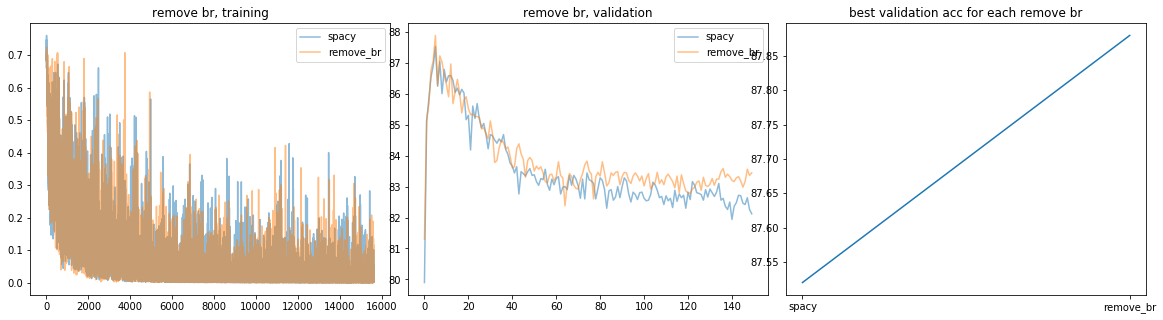

('remove_br', 87.88)

In [65]:
#SHOW GRAPH
loss_lists, val_acc_lists = dict(), dict()

for n in ["spacy", "remove_br"]:
    loss_lists[n] = unpickle_from_file('imdb_{}_loss_ngram_1_maxvocab_10000_emb_128_batch_32_lr_0.01/loss.p'.format(n))
    val_acc_lists[n] = unpickle_from_file('imdb_{}_loss_ngram_1_maxvocab_10000_emb_128_batch_32_lr_0.01/acc.p'.format(n))

best_hyperparam, best_val = plot_train_validation(loss_lists, val_acc_lists, "remove br", True)
best_hyperparam, best_val

# Hyperparam search for max_vocab_size

(outdated) Maybe the reason ngrams didn't perform so well is because the number of tokens explodes but we restrict max_vocab_size to be too small. We try bigger max_vocab_size in order to see if it exceeds the performance of 1gram model. However, it doesn't seem to be the case. 87.28 still lower than 87.46.

Try bigger max_vocab_size

In [ ]:
train_data_tokens, train_targets, val_data_tokens, val_targets, test_data_tokens, test_targets = imdb_data_tokens(2)

ngram_train("remove_br", 1, 20000, 128, 25, 0.01, 32)
ngram_train("remove_br", 1, 30000, 128, 25, 0.01, 32)
ngram_train("remove_br", 1, 40000, 128, 25, 0.01, 32)
ngram_train("remove_br", 1, 50000, 128, 25, 0.01, 32)
ngram_train("remove_br", 1, 60000, 128, 25, 0.01, 32)
ngram_train("remove_br", 1, 70000, 128, 25, 0.01, 32)
ngram_train("remove_br", 1, 80000, 128, 25, 0.01, 32)
ngram_train("remove_br", 1, 160000, 128, 25, 0.01, 32)

[10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 160000] [87.88, 87.72, 88.12, 88.5, 88.48, 82.02, 80.5, 87.9, 87.84]


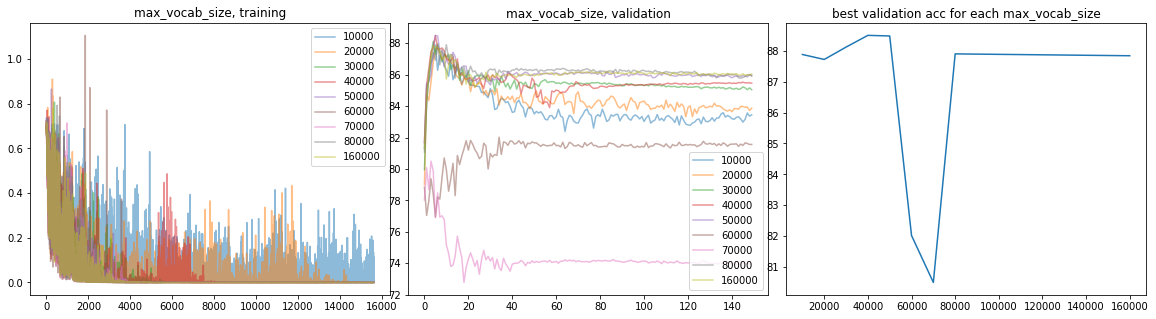

(40000, 88.5)

In [66]:
#SHOW GRAPH
loss_lists, val_acc_lists = dict(), dict()
for n in [10000,20000,30000,40000,50000,60000,70000,80000,160000]:
    loss_lists[n] = unpickle_from_file('imdb_remove_br_loss_ngram_1_maxvocab_{}_emb_128_batch_32_lr_0.01/loss.p'.format(n))
    val_acc_lists[n] = unpickle_from_file('imdb_remove_br_loss_ngram_1_maxvocab_{}_emb_128_batch_32_lr_0.01/acc.p'.format(n))
best_hyperparam, best_val = plot_train_validation(loss_lists, val_acc_lists, "max_vocab_size")
best_hyperparam, best_val

# Hyperparam search for emb_dim (2^5, ..., 2^11)
emb_dim=64 seems to perform best

In [ ]:
train_data_tokens, train_targets, val_data_tokens, val_targets, test_data_tokens, test_targets = imdb_data_tokens(2)

for n in [1,2,4,8,16,32,64,128,256,512,1024]:
    ngram_train("remove_br", 1, 40000, n, 25, 0.01, 32)

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] [87.0, 87.64, 88.14, 88.14, 88.2, 88.16, 88.08, 88.5, 88.16, 87.74, 87.26]


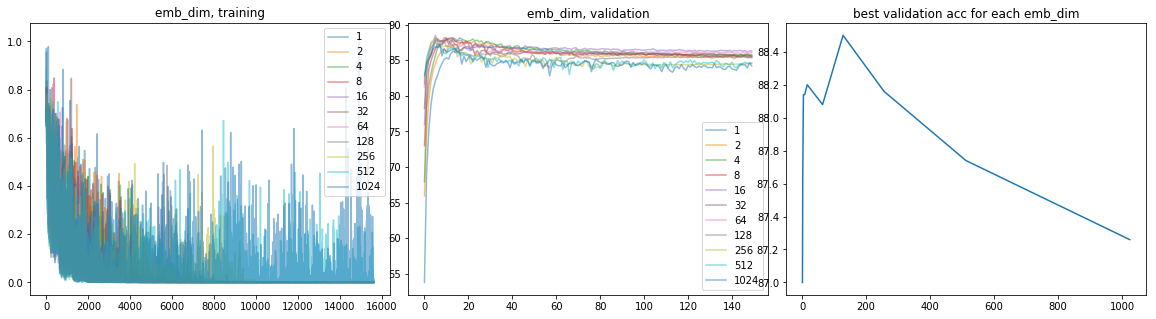

(128, 88.5)

In [67]:
#SHOW GRAPH
loss_lists, val_acc_lists = dict(), dict()
for n in [1,2,4,8,16,32,64,128,256,512,1024]:
    loss_lists[n] = unpickle_from_file('imdb_remove_br_loss_ngram_1_maxvocab_40000_emb_{}_batch_32_lr_0.01/loss.p'.format(n))
    val_acc_lists[n] = unpickle_from_file('imdb_remove_br_loss_ngram_1_maxvocab_40000_emb_{}_batch_32_lr_0.01/acc.p'.format(n))
best_hyperparam, best_val = plot_train_validation(loss_lists, val_acc_lists, "emb_dim")
best_hyperparam, best_val

# SGD, learning rate, linear annealing

In [ ]:
train_data_tokens, train_targets, val_data_tokens, val_targets, test_data_tokens, test_targets = imdb_data_tokens(2)
ngram_train("sgd", 1, 40000, 128, 50, 0.01, 32, 'sgd')

['sgd', 'adam'] [68.74, 88.5]


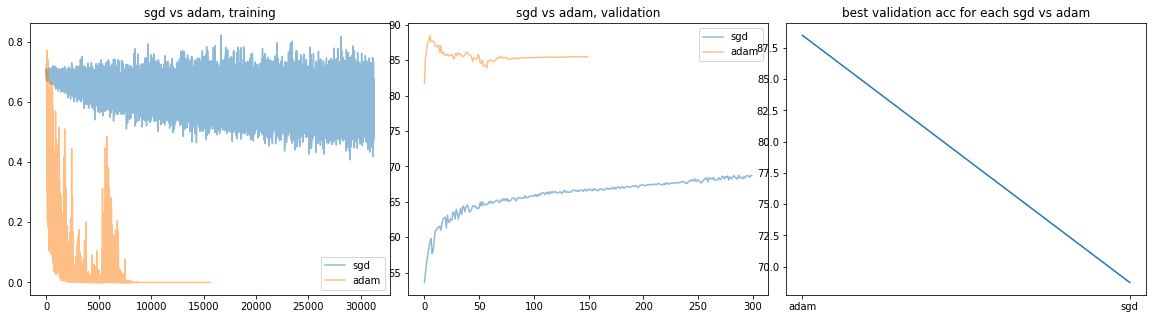

('adam', 88.5)

In [68]:

loss_lists, val_acc_lists = dict(), dict()
loss_lists['sgd'] = unpickle_from_file('imdb_sgd_loss_ngram_1_maxvocab_40000_emb_128_batch_32_lr_0.01/loss.p')
val_acc_lists['sgd'] = unpickle_from_file('imdb_sgd_loss_ngram_1_maxvocab_40000_emb_128_batch_32_lr_0.01/acc.p')
loss_lists['adam'] = unpickle_from_file('imdb_remove_br_loss_ngram_1_maxvocab_40000_emb_128_batch_32_lr_0.01/loss.p')
val_acc_lists['adam'] = unpickle_from_file('imdb_remove_br_loss_ngram_1_maxvocab_40000_emb_128_batch_32_lr_0.01/acc.p')
best_hyperparam, best_val = plot_train_validation(loss_lists, val_acc_lists, "sgd vs adam")
best_hyperparam, best_val

In [ ]:
train_data_tokens, train_targets, val_data_tokens, val_targets, test_data_tokens, test_targets = imdb_data_tokens(2)
for lr in [0.1,1,10,100]:
    ngram_train("sgd", 1, 40000, 128, 50, lr, 32, 'sgd')

[0.01, 0.1, 1, 10, 100] [68.74, 79.5, 85.76, 87.32, 50.0]


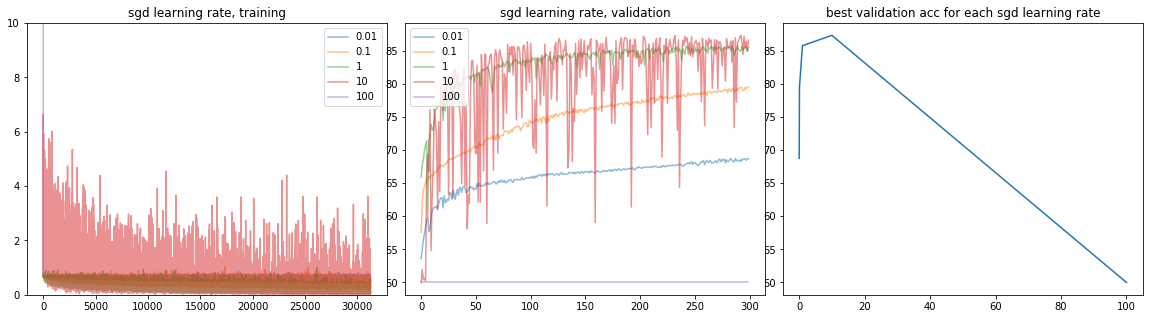

(10, 87.32)

In [86]:
loss_lists, val_acc_lists = dict(), dict()
for n in [0.01, 0.1,1,10,100]:
    loss_lists[n] = unpickle_from_file('imdb_sgd_loss_ngram_1_maxvocab_40000_emb_128_batch_32_lr_{}/loss.p'.format(n))
    val_acc_lists[n] = unpickle_from_file('imdb_sgd_loss_ngram_1_maxvocab_40000_emb_128_batch_32_lr_{}/acc.p'.format(n))
best_hyperparam, best_val = plot_train_validation(loss_lists, val_acc_lists, "sgd learning rate")
best_hyperparam, best_val

In [ ]:
train_data_tokens, train_targets, val_data_tokens, val_targets, test_data_tokens, test_targets = imdb_data_tokens(2)
ngram_train("sgd_linear_annealing", 1, 40000, 128, 50, 10, 32, 'sgd_linear_annealing',100)

In [ ]:
ngram_train("sgd_linear_annealing_51", 1, 40000, 128, 50, 10, 32, 'sgd_linear_annealing',51)

['sgd', 'sgd_linear_annealing_a', 'sgd_linear_annealing_b'] [87.32, 87.38, 86.9]


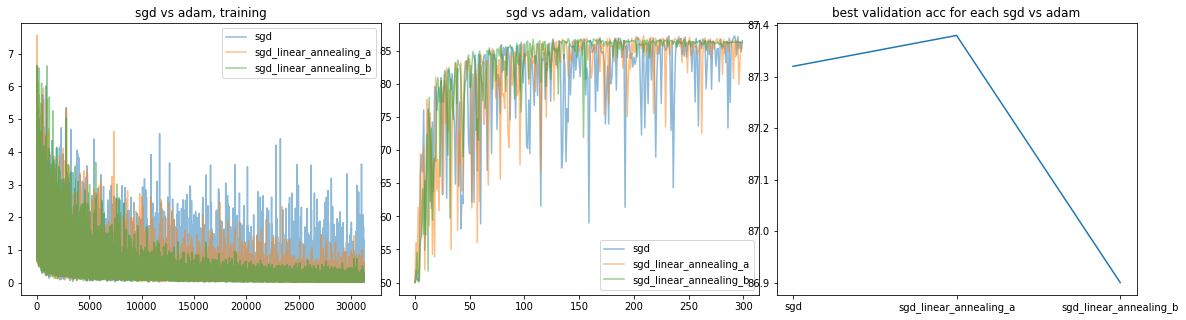

('sgd_linear_annealing_a', 87.38)

In [70]:
loss_lists, val_acc_lists = dict(), dict()
loss_lists['sgd'] = unpickle_from_file('imdb_sgd_loss_ngram_1_maxvocab_40000_emb_128_batch_32_lr_10/loss.p')
val_acc_lists['sgd'] = unpickle_from_file('imdb_sgd_loss_ngram_1_maxvocab_40000_emb_128_batch_32_lr_10/acc.p')
loss_lists['sgd_linear_annealing_a'] = unpickle_from_file('imdb_sgd_linear_annealing_loss_ngram_1_maxvocab_40000_emb_128_batch_32_lr_10/loss.p')
val_acc_lists['sgd_linear_annealing_a'] = unpickle_from_file('imdb_sgd_linear_annealing_loss_ngram_1_maxvocab_40000_emb_128_batch_32_lr_10/acc.p')
loss_lists['sgd_linear_annealing_b'] = unpickle_from_file('imdb_sgd_linear_annealing_51_loss_ngram_1_maxvocab_40000_emb_128_batch_32_lr_10/loss.p')
val_acc_lists['sgd_linear_annealing_b'] = unpickle_from_file('imdb_sgd_linear_annealing_51_loss_ngram_1_maxvocab_40000_emb_128_batch_32_lr_10/acc.p')
best_hyperparam, best_val = plot_train_validation(loss_lists, val_acc_lists, "sgd vs adam")
best_hyperparam, best_val

# Result of best model

In [61]:
ngram_show_result('imdb_remove_br_loss_ngram_1_maxvocab_40000_emb_128_batch_32_lr_0.01/epoch_0_step_600.p', 1, 40000, 128, 128, "test")

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
test acc: 85.24


In [54]:
#SHOW 3 CORRECT 3 INCORRECT RESULT OF THE MODEL, VALIDATION SET
ngram_show_result('imdb_remove_br_loss_ngram_1_maxvocab_40000_emb_128_batch_32_lr_0.01/epoch_0_step_600.p', 1, 40000, 128, 128, "val")

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
val acc: 88.5
Correct examples:
true label is neg , prediction is neg :
 as a former <unk> this was one of the worst submarine movies i have ever seen first of all a mutiny aboard any us naval vessel particularly a nuclear powered trident submarine in unthinkable these men are the best of the best and are dedicated to their mission the responsibility they carry is awesome and they take it very seriously all the way from the captain to the most junior crew member i could never see a crew of any ship split their alliance between the captain and the executive officer an executive officer who acted as the character played by denzel washington did would be relieved of his duties and court <unk> then drummed from the navy it is no surprise the navy refused to send a technical adviser to help in making this film lastly if any member of a submarine crew made the amount of noise made underway on this vessel they wou

In [55]:
#SHOW 3 CORRECT 3 INCORRECT RESULT OF THE MODEL, VALIDATION SET
ngram_show_result('imdb_remove_br_loss_ngram_1_maxvocab_40000_emb_128_batch_32_lr_0.01/epoch_0_step_600.p', 1, 40000, 128, 128, "val")

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
val acc: 88.5
Correct examples:
true label is pos , prediction is pos :
 this is a more interesting than usual porn movie because it is a fantasy adventure the production values are high and the acting <unk> it or not pretty good especially jenna jameson it`s also in widescreen which helps it gives a feeling of a real motion picture and not a porn movie but of course it is a porn and a really good one with nice costumes fine atmosphere and scenery and by the way the sex is hot   watch out for this one ...
original sentense
This is a more interesting than usual porn movie, because it is a fantasy adventure.The production values are high and the acting is(believe it or not) pretty good,especially Jenna Jameson.It`s also in widescreen which helps,it gives a feeling of a real motion picture and NOT a porn movie.But,of course it is a porn and a really good one with nice costumes,fine atmosphere and scenery.And b

In [58]:
#SHOW 3 CORRECT 3 INCORRECT RESULT OF THE MODEL, VALIDATION SET
ngram_show_result('imdb_remove_br_loss_ngram_1_maxvocab_40000_emb_128_batch_32_lr_0.01/epoch_0_step_600.p', 1, 40000, 128, 128, "val")

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
val acc: 88.5
Correct examples:
true label is neg , prediction is neg :
 sometimes making something strange and contemporary does n't always work to everyone 's advantage while i will admit that the set design and concept of the film was rather interesting the execution of these ideas into one <unk> story just did n't work this film was so hideously slow and pointless not even robin williams could save this garbage it 's obvious barry levinson 's dream fell flat on its face but he should have warned the rest of the world about this slop
original sentense
Sometimes, making something strange and contemporary doesn't always work to everyone's advantage. While I will admit that the set design and concept of the film was rather interesting, the execution of these ideas into one congruent story just didn't work. This film was so hideously slow and pointless, not even Robin Williams could save this garbage. It's o

In [59]:
#SHOW 3 CORRECT 3 INCORRECT RESULT OF THE MODEL, VALIDATION SET
ngram_show_result('imdb_remove_br_loss_ngram_1_maxvocab_40000_emb_128_batch_32_lr_0.01/epoch_0_step_600.p', 1, 40000, 128, 128, "val")

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
val acc: 88.5
Correct examples:
true label is pos , prediction is pos :
 i find i enjoy this show but the format needs some work first off the good attributes i like how this show will take us through the day to day life of an addict because the producers have a knack at getting the addict to show us how bad they 've allowed their lives to become this is followed by an intervention which is then followed by an outcome intervention does n't candy coat things and sometimes the outcome often short term due to the constraints of time between filming and airing is a negative outcome this makes the positive outcomes all the better   another thing i like about the show is the quality of the camera work given the reality that these cameramen have to squeeze anywhere and do n't have the benefit of re shooting scenes the photography is surprisingly good and stable it 's actually superior to scripted shows like the sh

In [60]:
#SHOW 3 CORRECT 3 INCORRECT RESULT OF THE MODEL, VALIDATION SET
ngram_show_result('imdb_remove_br_loss_ngram_1_maxvocab_40000_emb_128_batch_32_lr_0.01/epoch_0_step_600.p', 1, 40000, 128, 128, "val")

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
val acc: 88.5
Correct examples:
true label is pos , prediction is pos :
 this gem for gore lovers is extremely underrated it 's pure delight and fun gratuitous <unk> of blood insanity and black humor which can please even the most demanding lover of the genre a full exploitation of the almost universal fear of dentists and flawlessly shot only for the connoisseurs
original sentense
This gem for gore lovers is extremely underrated. It's pure delight and fun! Gratuitous servings of blood, insanity and black humor, which can please even the most demanding lover of the genre. A full exploitation of the almost universal fear of dentists and flawlessly shot. Only for the connoisseurs.
true label is neg , prediction is neg :
 this film is so ridiculously idiot that you may actually laugh at it but no even this is too much for this lost meters of celluloid i found it as an offer in a magazine and that 's why i 've 

In [78]:
train_data_tokens, train_targets, val_data_tokens, val_targets, test_data_tokens, test_targets = imdb_data_tokens(2)

ngram_train("test1", 1, 10000, 128, 25, 0.01, 32)

Token id 6260 ; token coupled
Token coupled; token id 6260
Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
saved imdb_test1_loss_ngram_1_maxvocab_10000_emb_128_batch_32_lr_0.01/epoch_0_step_100.p
Epoch: [1/25], Step: [101/625], Validation Acc: 80.06
saved imdb_test1_loss_ngram_1_maxvocab_10000_emb_128_batch_32_lr_0.01/epoch_0_step_200.p
Epoch: [1/25], Step: [201/625], Validation Acc: 84.78
saved imdb_test1_loss_ngram_1_maxvocab_10000_emb_128_batch_32_lr_0.01/epoch_0_step_300.p
Epoch: [1/25], Step: [301/625], Validation Acc: 85.9
saved imdb_test1_loss_ngram_1_maxvocab_10000_emb_128_batch_32_lr_0.01/epoch_0_step_400.p
Epoch: [1/25], Step: [401/625], Validation Acc: 86.66
saved imdb_test1_loss_ngram_1_maxvocab_10000_emb_128_batch_32_lr_0.01/epoch_0_step_500.p
Epoch: [1/25], Step: [501/625], Validation Acc: 87.26
Epoch: [1/25], Step: [601/625], Validation Acc: 87.18
saved imdb_test1_loss_ngram_1_maxvocab_10000_emb_128_batch_32_lr_0.01/epoch_1_step_100.p
Epoc

Epoch: [24/25], Step: [201/625], Validation Acc: 82.82
Epoch: [24/25], Step: [301/625], Validation Acc: 83.02
Epoch: [24/25], Step: [401/625], Validation Acc: 82.9
Epoch: [24/25], Step: [501/625], Validation Acc: 82.94
Epoch: [24/25], Step: [601/625], Validation Acc: 82.72
Epoch: [25/25], Step: [101/625], Validation Acc: 82.98
Epoch: [25/25], Step: [201/625], Validation Acc: 83.08
Epoch: [25/25], Step: [301/625], Validation Acc: 83.0
Epoch: [25/25], Step: [401/625], Validation Acc: 82.96
Epoch: [25/25], Step: [501/625], Validation Acc: 83.2
Epoch: [25/25], Step: [601/625], Validation Acc: 83.22


In [91]:
#compare two tokenizers
spacy_tokens_list = imdb_data_tokens(0)
toktok_tokens_list = imdb_data_tokens(1)
for i, sent in enumerate(spacy_tokens_list[0]):
    toktok_sent = toktok_tokens_list[0][i]
    for j, token in enumerate(sent):
        if token != toktok_sent[j]:
            print(i)
            print(sent[j-1], toktok_sent[j-1])
            print(sent[j], toktok_sent[j])
            print(sent[j+1], toktok_sent[j+1])
            print()
            break
    if i>25:
        break

0
in in
years years.
a a

1
pluto pluto
's s
judgment judgment

2
should should
be be.
it it

3
with with
adventure adventure.
the the

4
a a
first first-class
class thriller

5
i i
've ve
ever ever

6
men men
's s
sporting sporting

7
an an
ever ever-declining
declining spiral

8
comment comment
posted posted.
piedras piedras

9
as as
templar templar.
it it

10
this this
movie movie.
not not

11
a a
top top-notch
notch movie

12
ever ever
seen seen.
the the

13
years years
co co-funded
funded by

14
films.<br films.<br
/><br ><br
/>did >did

15
a a
full full-size
size screen

16
sinatra sinatra
's s
first first

17
i i
love love.
some some

18
saget saget
ok ok.
who who

19
and and
cry cry.
at at

20
three three
flash flash-backs
backs introduce

21
was was
teaching teaching.
the the

22
with with
everyone everyone.
his his

23
years years
ago ago.
i i

24
are are
dumb dumb.
this this

25
insane insane
time time-travelling
travelling action

26
i i
did didn
n't t

